# A Faster SparseNet Algorithm

Abhinav Madahar <abhinav.madahar@rutgers.edu>, James Abello Monedero <abelloj@cs.rutgers.edu>

---

The existing SparseNet algorithm is slow.
It is:
```
    Algorithm SparseNet(G: graph) -> array of paths:
        Find the distance matrix of G
        Set the configuration to an empty list
        Find the longest path in G using the distance matrix 
        Append the longest path in G to the configuration
        Until all vertices in G are in the configuration or adjacent to a vertex in it:
            Find the vertex in G farthest from all the vertices in the configuration using the distance matrix
            Find a path from the configuration to the vertex
            Append that path to the configuration
        Return the configuration
```

It's slow mainly because we need to find the distance matrix.
Also, we need to store the entire graph in memory, which is not feasible for very large graphs.
To remedy this, we introduce a new algorithm which finds a SparseNet for a graph without needing a distance matrix and without storing the entire graph in memory.
First, let's import some libraries which we need.

In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random as R
from graph.sparsenet import sparsenet as find_sparsenet
from time import time
from multiprocessing import Pool, cpu_count

Now, let's load a sample graph.
We want to make sure that the graph is connected, so we take its largest connected component.

In [44]:
G = nx.gnm_random_graph(2000, 62250)
G = G.subgraph(next(nx.connected_components(G)))
# pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, pos=pos, node_size=1)
# nx.draw_networkx_edges(G, pos=pos, alpha=0.01);

Now that we have a graph, we can find a SparseNet for it.

In [45]:
sparsenet = nx.Graph()
components = {}
n_components = 0
for (src, dest, is_edge) in ((src, dest, True) for (src, dest) in G.edges()):
    if not is_edge:
        sparsenet.add_node(src)
        sparsenet.add_node(dest)
    elif src not in sparsenet.nodes() and dest not in sparsenet.nodes():
        sparsenet.add_edge(src, dest)
        components[src] = components[dest] = n_components
        n_components += 1
    elif src in sparsenet.nodes() and dest not in sparsenet.nodes():
        sparsenet.add_edge(src, dest)
        components[dest] = components[src]
    elif src not in sparsenet.nodes() and dest in sparsenet.nodes():
        sparsenet.add_edge(src, dest)
        components[src] = components[dest]
    elif src in sparsenet.nodes() and dest in sparsenet.nodes() and components[src] != components[dest]:
        sparsenet.add_edge(src, dest)
        old_component = components[dest]
        for node, component in components.items():
            if component == old_component:
                components[node] = components[src]
    elif src in sparsenet.nodes() and dest in sparsenet.nodes() and components[src] == components[dest]:
        hotspot = src if len(sparsenet.adj[src]) > len(sparsenet.adj[dest]) else dest
        coldspot = src if len(sparsenet.adj[src]) <= len(sparsenet.adj[dest]) else dest
        neighbour_to_drop = nx.shortest_path(sparsenet, coldspot, hotspot)[1]
        if len(sparsenet.adj[neighbour_to_drop]) < len(sparsenet.adj[hotspot]):
            sparsenet.remove_edge(coldspot, neighbour_to_drop)
            sparsenet.add_edge(coldspot, hotspot)

Let's see what it looks like.

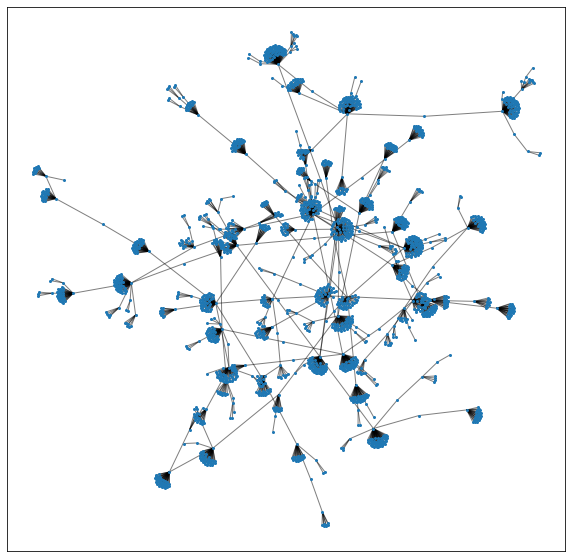

In [46]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(sparsenet)
nx.draw_networkx_nodes(sparsenet, pos=pos, node_size=4)
nx.draw_networkx_edges(sparsenet, pos=pos, alpha=0.5);

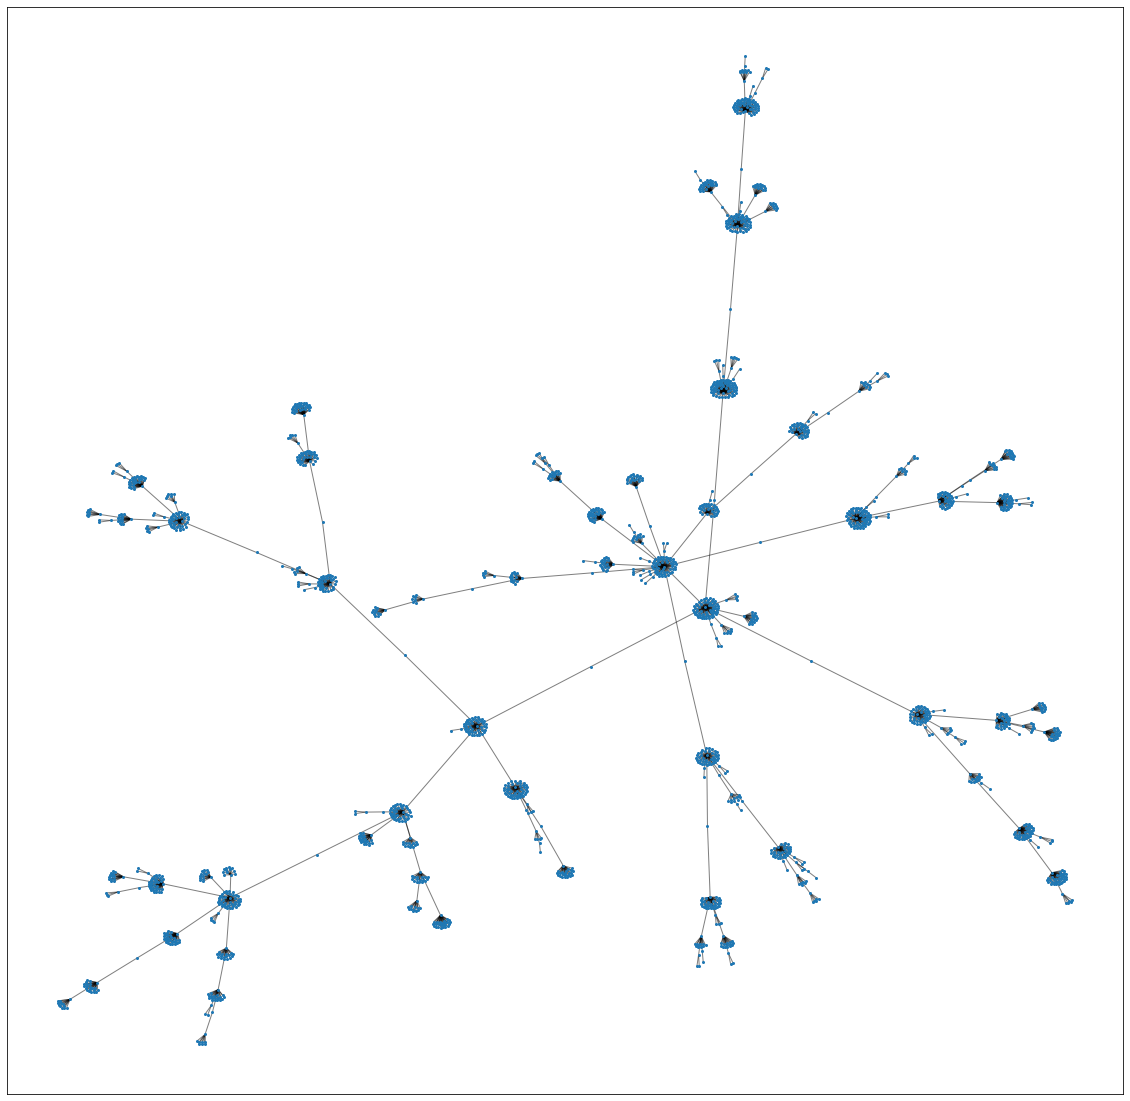

In [49]:
plt.figure(figsize=(20, 20))
pos2 = nx.spring_layout(sparsenet, pos=pos, iterations=400)
nx.draw_networkx_nodes(sparsenet, pos=pos2, node_size=4)
nx.draw_networkx_edges(sparsenet, pos=pos2, alpha=0.5);

We want to make sure that this new algorithm gives a valid SparseNet.
To prove this, we run the old SparseNet algorithm.
Every time we try to add a path, we check to see if that path exists in the new algorithm's SparseNet.
If it exists, then we add that path and continue.
If it does not exist, then we do not add that path; instead, we find a different path and see if that path exists.
At the end, if we can finish making a SparseNet, then we know that we've made a legitimate SparseNet using the new algorith.

In [7]:
def is_sparsenet_given(sparsenet: nx.Graph, G: nx.Graph, distance_matrix: np.array, vertex_to_index: dict, configuration: list = []) -> bool:
    """
    Determines if a subgraph is a sparsenet of a graph.
    """
    index_to_vertex = { i:v for v, i in vertex_to_index.items() }
    if configuration == []:
        for src, dest in np.argwhere(distance_matrix == distance_matrix.max()):
            for path in nx.all_shortest_paths(G, src, dest):
                if all(sparsenet.has_edge(*edge) for edge in zip(path, path[1:])) and is_sparsenet_given(sparsenet, G, distance_matrix, vertex_to_index, [path]):
                    return True
    else:
        # we already have some paths in the configuration, so we need to find more paths and see if they work
        points_in_configuration = sorted(list(set(sum(configuration, []))))
        distance_to_point_in_configuration = distance_matrix[points_in_configuration]
        distance_to_configuration = distance_to_point_in_configuration.min(axis=0)
        farthest_points = np.argwhere(distance_to_configuration == distance_to_configuration.max()).flatten()
        if distance_to_configuration.max() < 2:
            return True
        for farthest in farthest_points:
            for src_on_config in np.argwhere(distance_to_point_in_configuration[:, farthest] == distance_to_point_in_configuration[:, farthest].min()).flatten():
                if nx.shortest_path_length(sparsenet, src_on_config, farthest) == distance_matrix[(src_on_config, farthest)]:
                    for path in nx.all_shortest_paths(sparsenet, src_on_config, farthest):
                        if is_sparsenet_given(sparsenet, G, distance_matrix, vertex_to_index, configuration + [path]):
                            return True
    return False

distance_matrix = np.array(nx.floyd_warshall_numpy(G))
vertex_to_index = { node:i for i, node in enumerate(G.nodes) }
is_sparsenet_given(sparsenet, G, distance_matrix, vertex_to_index)

False

Now, let's compare it with a SparseNet made using the old algorithm.

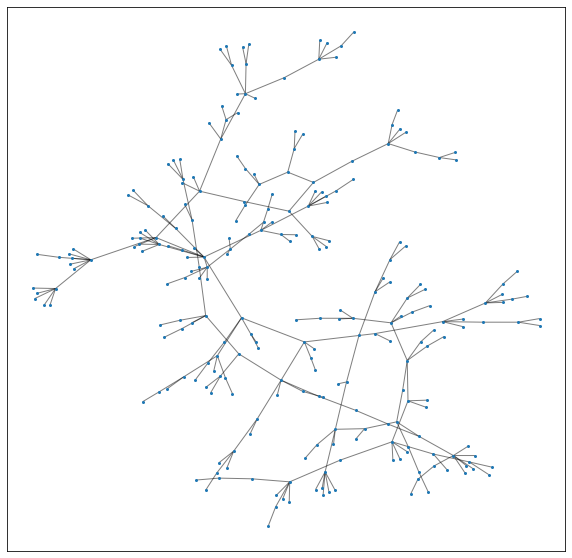

In [12]:
distance_matrix = np.array(nx.floyd_warshall_numpy(G))
vertex_to_index = { node:i for i, node in enumerate(G.nodes) }
edges = sum(([(src, dest) for src, dest in zip(path, path[1:])] for path in find_sparsenet(G, distance_matrix, vertex_to_index)), [])
bona_fide_sparsenet = nx.edge_subgraph(G, edges)
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(bona_fide_sparsenet)
nx.draw_networkx_nodes(bona_fide_sparsenet, pos=pos, node_size=4)
nx.draw_networkx_edges(bona_fide_sparsenet, pos=pos, alpha=0.5);

Let's compare how tightly-clustered the nodes are in the VerySparseNet compared to the regular SparseNet.
To do so, we find the median distance from one node to the other in both.

In [7]:
sparsenet_distance_matrix = np.array(nx.floyd_warshall_numpy(sparsenet))
bona_fide_sparsenet_distance_matrix = np.array(nx.floyd_warshall_numpy(bona_fide_sparsenet))

In [8]:
np.median(sparsenet_distance_matrix), np.median(bona_fide_sparsenet_distance_matrix)

(8.0, 9.0)

In [9]:
np.mean(sparsenet_distance_matrix), np.mean(bona_fide_sparsenet_distance_matrix)

(8.339800970952082, 8.946500862889309)

Let's compare them.

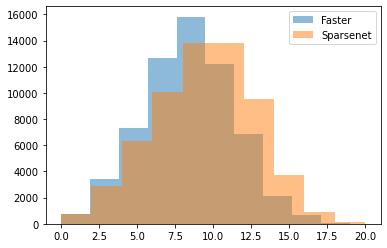

In [10]:
plt.hist(np.array(sparsenet_distance_matrix).flatten(), alpha=0.5, label='Faster')
plt.hist(np.array(bona_fide_sparsenet_distance_matrix).flatten(), alpha=0.5, label='Sparsenet')
plt.legend();

Let's run this trial many times with different graphs to see which technique gets a tighter clustering.

In [11]:
def stats(a):
    source = nx.gnm_random_graph(250, 0.1 * (250 * 249 / 2))
    source = source.subgraph(next(nx.connected_components(source)))
    sparsenet = nx.Graph()
    components = {}
    n_components = 0
    for src, dest in source.edges():
        if src not in sparsenet.nodes() and dest not in sparsenet.nodes():
            sparsenet.add_edge(src, dest)
            components[src] = components[dest] = n_components
            n_components += 1
        elif src in sparsenet.nodes() and dest not in sparsenet.nodes():
            sparsenet.add_edge(src, dest)
            components[dest] = components[src]
        elif src not in sparsenet.nodes() and dest in sparsenet.nodes():
            sparsenet.add_edge(src, dest)
            components[src] = components[dest]
        elif src in sparsenet.nodes() and dest in sparsenet.nodes() and components[src] != components[dest]:
            sparsenet.add_edge(src, dest)
            old_component = components[dest]
            for node, component in components.items():
                if component == old_component:
                    components[node] = components[src]
        elif src in sparsenet.nodes() and dest in sparsenet.nodes() and components[src] == components[dest]:
            hotspot = src if len(sparsenet.adj[src]) > len(sparsenet.adj[dest]) else dest
            coldspot = src if len(sparsenet.adj[src]) <= len(sparsenet.adj[dest]) else dest
            neighbour_to_drop = nx.shortest_path(sparsenet, coldspot, hotspot)[1]
            if len(sparsenet.adj[neighbour_to_drop]) < len(sparsenet.adj[hotspot]):
                sparsenet.remove_edge(coldspot, neighbour_to_drop)
                sparsenet.add_edge(coldspot, hotspot)

    distance_matrix = nx.floyd_warshall_numpy(source)
    vertex_to_index = { node:i for i, node in enumerate(source.nodes) }
    edges = sum(([(src, dest) for src, dest in zip(path, path[1:])] for path in find_sparsenet(source, distance_matrix, vertex_to_index)), [])
    bona_fide_sparsenet = nx.edge_subgraph(source, edges)
    sparsenet_distance_matrix = np.array(nx.floyd_warshall_numpy(sparsenet))
    bona_fide_sparsenet_distance_matrix = np.array(nx.floyd_warshall_numpy(bona_fide_sparsenet))
    return (
        (np.median(sparsenet_distance_matrix), np.median(bona_fide_sparsenet_distance_matrix)),
        (np.mean(sparsenet_distance_matrix), np.mean(bona_fide_sparsenet_distance_matrix)),
        (np.max(sparsenet_distance_matrix), np.max(bona_fide_sparsenet_distance_matrix))
    )

with Pool(cpu_count()) as p:
    statistics = p.map(stats, [1] * cpu_count() * 10)

In [12]:
np.array(statistics).mean(axis=0)

array([[ 6.20625   ,  5.879375  ],
       [ 6.28648384,  5.67054492],
       [14.1875    , 10.90125   ]])

Let's see how quickly the new algorithm runs.

In [ ]:
def duration(V, E):
    starting_time = time()
    G = nx.gnm_random_graph(V, E)
    G = G.subgraph(next(nx.connected_components(G)))
    sparsenet = nx.Graph()
    components = {}
    n_components = 0
    for src, dest in G.edges():
        if src not in sparsenet.nodes() and dest not in sparsenet.nodes():
            sparsenet.add_edge(src, dest)
            components[src] = components[dest] = n_components
            n_components += 1
        elif src in sparsenet.nodes() and dest not in sparsenet.nodes():
            sparsenet.add_edge(src, dest)
            components[dest] = components[src]
        elif src not in sparsenet.nodes() and dest in sparsenet.nodes():
            sparsenet.add_edge(src, dest)
            components[src] = components[dest]
        elif src in sparsenet.nodes() and dest in sparsenet.nodes() and components[src] != components[dest]:
            sparsenet.add_edge(src, dest)
            old_component = components[dest]
            for node, component in components.items():
                if component == old_component:
                    components[node] = components[src]
        elif src in sparsenet.nodes() and dest in sparsenet.nodes() and components[src] == components[dest]:
            hotspot = src if len(sparsenet.adj[src]) > len(sparsenet.adj[dest]) else dest
            coldspot = src if len(sparsenet.adj[src]) <= len(sparsenet.adj[dest]) else dest
            neighbour_to_drop = nx.shortest_path(sparsenet, coldspot, hotspot)[1]
            if len(sparsenet.adj[neighbour_to_drop]) < len(sparsenet.adj[hotspot]):
                sparsenet.remove_edge(coldspot, neighbour_to_drop)
                sparsenet.add_edge(coldspot, hotspot)
    return time() - starting_time

with Pool(cpu_count()) as p:
    V = list(range(500, 2000, 100))
    sizes = [(v, R.randint(v, 50 * v)) for v in V * cpu_count()]
    R.shuffle(sizes)
    new_times = p.starmap(duration, sizes)

Let's compare it with the original SparseNet algorithm.

In [ ]:
def old_duration(V, E):
    starting_time = time()
    G = nx.gnm_random_graph(V, E)
    G = G.subgraph(next(nx.connected_components(G)))
    distance_matrix = nx.floyd_warshall_numpy(G)
    vertex_to_index = { node:i for i, node in enumerate(G.nodes) }
    edges = sum(([(src, dest) for src, dest in zip(path, path[1:])] for path in find_sparsenet(G, distance_matrix, vertex_to_index)), [])
    bona_fide_sparsenet = nx.edge_subgraph(G, edges)
    return time() - starting_time

with Pool(cpu_count()) as p:
    old_times = p.starmap(old_duration, sizes)

In [ ]:
plt.figure(figsize=(20, 10))
plt.title('Time to calculate: New Algorithm vs Old Algorithm (area represents duration in seconds)')
plt.ylabel('Number of edges')
plt.xlabel('Number of vertices')
plt.scatter([x for x, y in sizes], [y for x, y in sizes], s=[t * 25 for t in old_times], label='Old algorithm')
plt.scatter([x for x, y in sizes], [y for x, y in sizes], s=[t * 25 for t in new_times], label='New algorithm')
plt.legend();